<h1>Dependencies</h1>
<p>The program relies on two modules: </p>
<ul>
  <li>NumPy for mathematical and matrix operations </li>
  <li>SciPy, particularly scipy.optimize, for solving simultaneous equations</li>
</ul>

In [1]:
import os
import numpy as np
import yaml 
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from validation_tests import *

<h1>Inputs</h1>
<p>Define the imputs based on the provided yaml file. The code belows extracts data for the pinion.</p>
<p>The parameters that will be needed are:</p>
<ul>
  <li>Normal module (mm) </li>
  <li>Pressure angle ($^{\circ}$) </li>
  <li>Helix angle ($^{\circ}$) </li>
  <li>Number of teeth</li>
  <li>Number of nodes along width</li>
  <li>Number of nodes along height</li>
</ul>
<p>The pressure and helix angle are converted to radians.</p>

In [2]:
with open('..\data\pinion.yml', 'r') as file:
    gear_data = yaml.safe_load(file)

m = gear_data['design']['mn']*1000
alpha = np.deg2rad(gear_data['design']['alpha_n_deg'])
beta = np.deg2rad(gear_data['design']['beta_deg'])
z = gear_data['design']['z']
R_p = m*z/2
R_b = R_p*np.cos(alpha)
w = gear_data['bending']['bending_z_points'] #nodes along width
h = gear_data['bending']['bending_r_points'] #nodes along height

K = w*h

path = os.getcwd()

<h1>Sorting input arrays of positions and displacements</h1>
In this section we define 2 functions dedicated for sorting the coordinates of nodes and the vectors of displacements. The arrays are sorted based on the node's location along the tooth width and height as such the sorter function will sort the incoming array based on those two dimensions. To account for every grid configuration the following sorting scheme was adopted:
<ol>
  <li>
    Dividing the tooth along its width into w sections such that in each section there are h nodes.
  </li>
  <li>
    Sort the h nodes in each section according to their height from minimum to maximum.
  </li>
</ol>
<p> According to the above described sorting convention the value of index $k$ is,</p>
 <div align="center">   $k  = (i - 1)*h + j$</div>
<p>where $i$ is the section number and $j$ the order along the height. 
</p>
<p>
  The array of displacements is sorted based on the sorting procedure for nodal positions as such it is important to keep track of the indices used to sort the position arrays in the $position\_sorter()$ function. This is done by calling $np.argsort()$. The sorting indices are then stored as global arrays to avoid excessive passage of large arrays while calling the $displacement\_sorter()$ function. The displacement sorted then takes in the same three arguments as the position sorter: number of nodes along height $h$, number of nodes along width $w$, and the unsorted array of displacement vectors.
</p>

In [3]:
def position_sorter(h, w, position_array):
    
    #sort_aguments_width/height must be defined so that displacements can be sorted according to the sorting
    #process of positions. Global scope is declared to avoid repetitive passage of arguments.   
    global sort_arguments_width
    global sort_arguments_height
    sort_arguments_width = np.argsort(position_array[:, 2]) #holds the arguments of nodes belonging to each section along width
    sort_arguments_height = np.zeros((h, w))                #defines how nodes are arranged along height on each section
    
    sorted_array = np.zeros((h, w, 3)) #will store the sorted tensor
    
    
    for i in range(w):                                                  #Divide tooth into w sections       
        section_nodes = position_array[sort_arguments_width[i*h:(i+1)*h]]   #Contains h nodes belonging to section i [x, y, z]  
        
        sort_height = np.argsort(section_nodes[:, 1])
        sort_arguments_height[:, i] = sort_height
        
        section_nodes = section_nodes[sort_height]                      #Sorted section i along y      
        sorted_array[:, i, :] = section_nodes.reshape((h,3))
        
    return sorted_array

def displacement_sorter(h, w, displacement_array):
    #uses the sort_aguments_width/height variable defined in the position sorter. 
    sorted_array = np.zeros((h, w, 3)) #will store the sorted tensor
    
    for i in range(w):                                                  #Divide tooth into w sections       
        section_nodes = displacement_array[sort_arguments_width[i*h: (i + 1)*h]]   #Contains h nodes belonging to section i [x, y, z]  
        section_nodes = section_nodes[sort_arguments_height[:, i].astype('uint8')]                      #Sorted section i along y      
        sorted_array[:, i, :] = section_nodes.reshape((h,3))
        
    return sorted_array

    

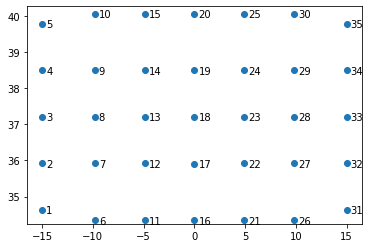

Displacements were sorted properly


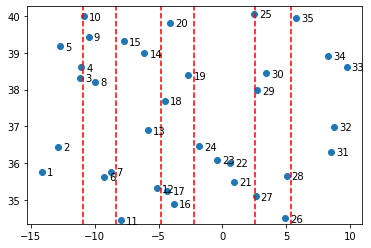

In [4]:
coefficient_dir = path + "/../coef_inf_temp211/"
nodal_positions0 = np.loadtxt(coefficient_dir+"Flexion_pignon_gauche_l_D0_Pt01.txt", skiprows=3, usecols=(0,1,2))
position_array = position_sorter(h, w, nodal_positions0)


displacement_array_l = np.loadtxt(coefficient_dir+"Flexion_pignon_gauche_l_D0_Pt01.txt", skiprows=3, usecols=(3,4,5))
displacement_array_b = np.loadtxt(coefficient_dir+"Flexion_pignon_gauche_b_D0_Pt01.txt", skiprows=3, usecols=(3,4,5))
displacement_array = displacement_sorter(h, w, displacement_array_l-displacement_array_b)

position_sorter_check(position_array)
print(equivalent_sort(nodal_positions0, displacement_array_l-displacement_array_b, position_array, displacement_array))
position_sorter_check(random=1, position_sorter = position_sorter, h = 5, w = 7)

<h1>Normal displacements</h1>

<p> In this section the nodal displacements in the normal direction are obtained for a given loading configuration. The function accepts the following input arguments the sorted displacement array and the sorted position array for a given loading configuration and outputs the normal displacement magnitudes for every node. Additional inputs are the helix angle $\beta$ and base radius $R_b$ which are constants with a global scope so not explicitly passed into the function. 
</p>

<p>The normal component of displacements is computed by taking the dot product of the displacement vector and the  normal vectors in the direction normal to the tooth as follows,</p>
<div align='center'>$U_n = U \cdot \hat{u_n} $</div>

<p>
  The first step in computation of the normal displacements then is defining the unit vector in the direction normal to the involute. Since the module is intended for any arbitrary grid the unit normal vector is computed for every node. The normal direction can be defined by the helix angle $\beta$ and the orientation of the line tangent to the base circle and passing through the contacting node $\psi$:
</p>

<div align="center"> $\hat{u_n} = \frac{1} {||\vec{u_n}||} \vec{u_n}$ $\ \ , \ \ \ \ where \ \ \vec{u_n} = \begin{bmatrix}
       cos(\psi) \\
       sin(\psi) \\
       sin(\beta) \\
     \end{bmatrix}$ </div>

<p>
  The angle $\psi$ is unknown. It will obtained using the basic geometric definition of an involute which states that the line normal to an involute flank is perpindicular to the base circle. This approach introduces two more unknowns: $R_{inv}$ - involute radius and $\phi$ - orientation of $R_b$; but yields a sufficient number of equations.
</p>
<div align="center"> $R_{inv} = \sqrt{R_{contact}^2 - R_b^2}$ </div>
<div>\begin{align}
  \begin{bmatrix}
         R_{inv}cos(\psi) \\
         R_{inv}sin(\psi) \\
       \end{bmatrix} &= \begin{bmatrix}
           R_{inv, x} \\
           R_{inv, y} \\
         \end{bmatrix} - \begin{bmatrix}
                R_{b}cos(\phi) \\
                R_{b}sin(\phi) \\
              \end{bmatrix}
  \end{align} </div>
<p>Where, $R_{contact}$ - distance from gear axis to contact point and $R_{b}$ - radius of base circle. </p>

<p>Equation 2 presents a system of non-linear equation which are solved using SciPy's numerical solver. Given the periodic nature of trigonometric functions, to ensure correct convergence starting estimates for $\psi$ and $\phi$ are provided which change depending on which flank is loaded. If the left flank is loaded the starting points are $\psi = 60 ^\circ \ \phi = 135 ^\circ$; if the right flank is loaded then $\psi = 120 ^\circ \ \phi = 45 ^\circ$.</p>
<br />



In [5]:
def normal_displacement(displacement_array, position_array, check = False):
    h, w, _ = position_array.shape
    start_estimate = (np.pi/3, 3*np.pi/4) if position_array[0,0, 0]<0 else (2*np.pi/3, np.pi/4)
    
    Psi = np.zeros((h, w, 3))
    Phi = np.zeros((h, w))
    
    for i in range(w):
        R_c = position_array[:, i, :2]
        eps = np.power(np.linalg.norm(R_c, axis=1)**2 - R_b**2, 0.5) 

        for j in range(h): #goes through the whole width at one height   
            def equations(p):
                phi, psi = p
                #return theta and angle of base radius
                return (R_c[j, 0] - R_b*np.cos(phi) - eps[j]*np.cos(psi), R_c[j, 1] - R_b*np.sin(phi) - eps[j]*np.sin(psi)) 

            phi, psi =  fsolve(equations, start_estimate)
            Psi[j, i, :] = np.array([np.cos(psi), np.sin(psi), np.sin(beta)])/np.linalg.norm([np.cos(psi), np.sin(psi), np.sin(beta)])
            Phi[j, i] =  phi
            
    Un = np.sum(np.multiply(displacement_array, Psi), axis=2)
    if check:
        return Un, Psi, Phi
    else:
        return Un

0
vectors are orthogonal


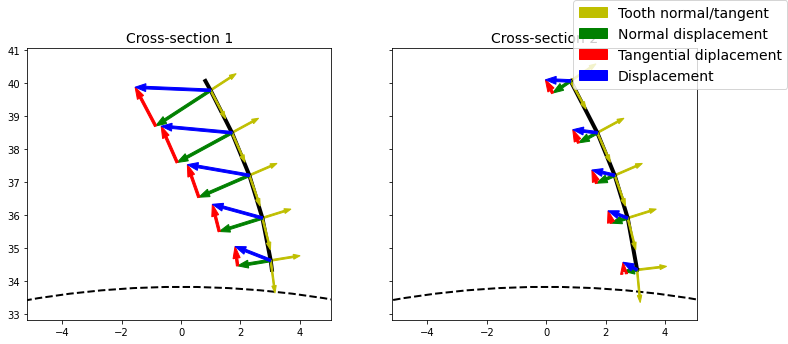

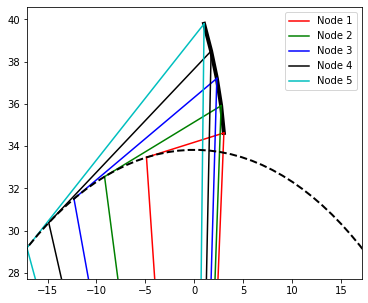

In [6]:
unn = normal_displacement_check(position_array, displacement_array, normal_displacement, R_b, sections = [0, 2], scale = 1000)
print("vectors are orthogonal") if normal_vector_check(position_array, displacement_array, normal_displacement, R_b) else print("not orthogonal")

<h2> Mode shape functions </h2>
The mode shape function G and H are ordered as follows:
<div align='center'>
$\begin{equation*}
G =
\begin{pmatrix}
g_1^1 & g_2^1 & \cdots & g_K^1 \\
g_1^2 & g_2^2 & \cdots & g_K^2 \\
\vdots  & \vdots  & \ddots & \vdots  \\
g_1^h & g_2^h & \cdots & g_K^h
\end{pmatrix}
\end{equation*}$
<span style="color:white">&ensp&ensp&ensp</span>
$\begin{equation*}
H =
\begin{pmatrix}
h_1^1 & h_2^1 & \cdots & h_K^1 \\
h_1^2 & h_2^2 & \cdots & h_K^2 \\
\vdots  & \vdots  & \ddots & \vdots  \\
h_1^w & h_2^w & \cdots & h_K^w
\end{pmatrix}
\end{equation*}$
</div>

<br /><br /><br />

<div align='center'>
$\begin{equation*}
F =
\begin{pmatrix}
f_1^1 & f_2^1 & \cdots & f_K^1 \\
f_1^2 & f_2^2 & \cdots & f_K^2 \\
\vdots  & \vdots  & \ddots & \vdots  \\
f_1^K & f_2^K & \cdots & f_K^K
\end{pmatrix} = 
\begin{pmatrix}
h_1^1 * g_1^1 & h_2^1 * g_2^1 & \cdots & h_K^1 * g_K^1 \\
h_1^2 * g_1^1 & h_2^2 * g_2^1 & \cdots & h_K^2 * g_K^1 \\
\vdots  & \vdots  & \ddots & \vdots  \\
h_1^1 * g_1^2 & h_2^1 * g_2^2 & \cdots & h_K^1 * g_K^2 \\
\vdots  & \vdots  & \ddots & \vdots  \\
h_1^w * g_1^h & h_2^w * g_2^h & \cdots & h_K^w * g_K^h
\end{pmatrix}
\end{equation*}$
</div>

In [7]:
np.set_printoptions(precision=4, suppress=True)
def mode(position_array, check = False ):
    h, w, _ = position_array.shape
    
    def G(h, w):
        #assuming equal spacing between nodes
        r = np.linalg.norm(position_array[:,:,:2], 2, axis = 2)
        r_max = np.max(r[-1, :])
        r_min = np.min(r[0, :])
        node_positions = (r.flatten("F") - r_min)/(r_max - r_min)
        G = np.zeros((h, w*h))
        
        for j in range(h): #for a continuous plot call g(100) and substitute the i in range with 5
            g_mode = np.power(node_positions, j)
            G[j, :] = g_mode
        return [G, node_positions] if check else G
    
    
    def H(h, w):
        z_max = np.max((position_array[:, -1, 2]))
        z_min = np.min((position_array[:, 0, 2]))
        node_positions = (position_array[:,:, 2] - z_min)/(z_max - z_min)
        H = np.zeros((w, w*h))
        for j in range(h):
            nodes_j = node_positions[j, :]
            for i in range(w):  
                if i == 0:
                    h_mode = np.ones((w))
                elif i == 1:
                    h_mode = 1 - np.dot(2, nodes_j)

                else:
                    mu = (i - 0.5)*np.pi
                    alpha = (np.sin(mu) - np.sinh(mu))/(np.cos(mu) - np.cosh(mu))
                    h_mode = np.sin( np.dot(mu, nodes_j) ) + np.sinh( np.dot(mu, nodes_j) )- alpha*(np.cos(np.dot(mu, nodes_j)) + np.cosh(np.dot(mu, nodes_j)))
            
                H[i, j::h] = h_mode
        return [H, node_positions] if check else H
    
    G = G(h, w) #rows represent some mode; columns are the points
    H = H(h, w) #rows represent some mode; columns are the points
    
    if check:
        G, nodes_g = G
        H, nodes_h = H
        F = np.zeros((h*w, h*w))
        for i in range(w):
            for j in range(h):
                k = h*i + j
                F[k, :] = np.multiply(G[j, :], H[i, :])      
        return nodes_g, nodes_h, G, H, F
    
    else:
        F = np.zeros((h*w, h*w))
        for i in range(w):
            for j in range(h):
                k = h*i + j
                F[k, :] = np.multiply(G[j, :], H[i, :])            
        return F

Good! r_coordinates are properly sorted. r-coordinates are increasing row to row.
Good! z_coordinates are properly sorted. z-coordinates are increasing column to column.


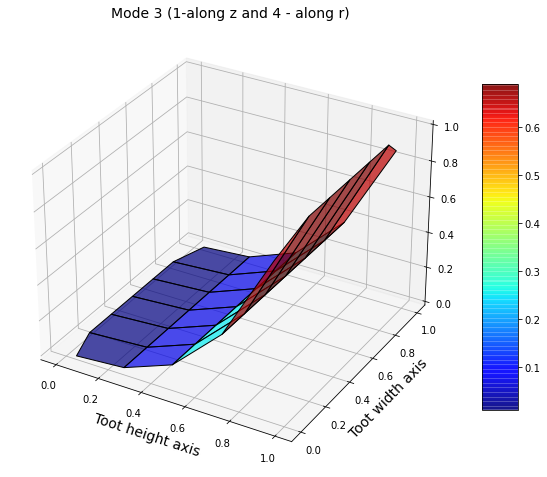

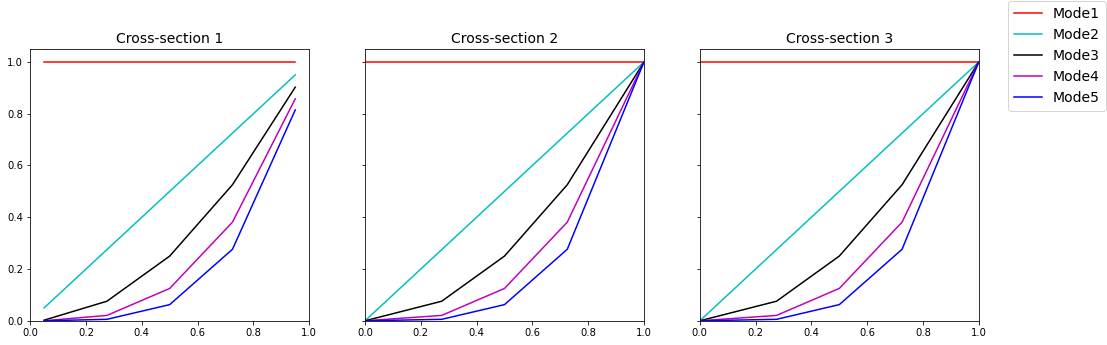

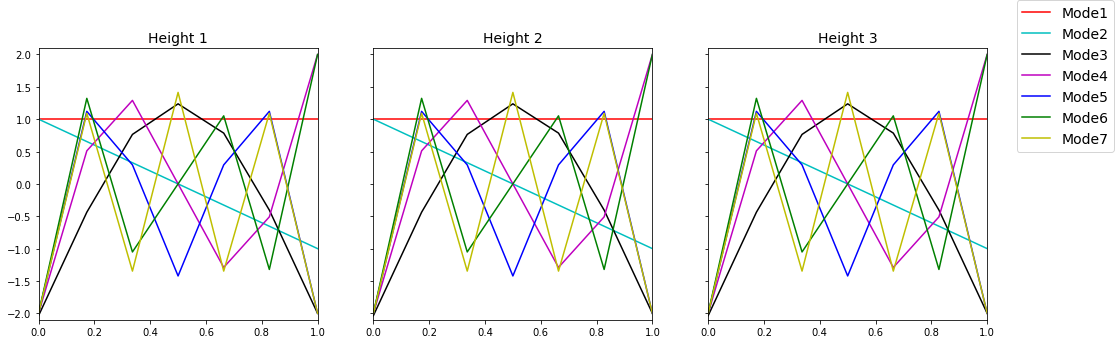

In [36]:
F = mode(position_array, check = True)
# for ind  in range(h*w):
#     print(F[-1][ind, 3:8])
F_check(F, mode_k  = 4)
G_check(F, [0, 3])
H_check(F, [0, 3])

#Seems correct I am getting the same expected shapes for all mode functions hwoever a mistake could be made 
# in row-wise ordering of the shape functions. VERIFY THAT ROW-WISE ORDER IS RIGHT.

<h2> Loops through displacement files</h2>
<div align='center'>$U = U_{free} - U_{blocked} $</div>

In [10]:
coefficient_dir = path + "\..\coef_inf_temp211"
nodal_positions0 = np.loadtxt(coefficient_dir+"\Flexion_pignon_gauche_l_D0_Pt01.txt", skiprows=3, usecols=(0,1,2))
position_array = position_sorter(h, w, nodal_positions0)
Un = np.zeros((K, K))
for k in range(1, K+1):
    #load displacements when flank is free and clamped. for clamped condition load last 3 columns
    free_directory = coefficient_dir + "\Flexion_pignon_gauche_l_D0_Pt{}.txt".format("0"+str(k) if k<10 else str(k))
    clamped_directory = coefficient_dir + "\Flexion_pignon_gauche_b_D0_Pt{}.txt".format("0"+str(k) if k<10 else str(k))
    free_n6 = np.loadtxt(free_directory, skiprows=3, usecols=(3,4,5))
    clamped_n6 = np.loadtxt(clamped_directory, skiprows=3, usecols=(3,4,5))
    displacement_net = free_n6 - clamped_n6
    
    displacement_array = displacement_sorter(h, w, displacement_net)

    un = normal_displacement(displacement_array, position_array, check=False)
    Un[k-1, :] = un.flatten("F")
    
#     Un = Un.reshape((5, 7), order="F")
#     print(Un.shape)
#     position_sorter_check(position_array)
#     print(equivalent_sort(nodal_positions0, displacement_net, nodal_positions, displacement_array))
#     unn = normal_displacement_check(position_array, displacement_array, sections = [0, w], scale = 1000)
#     print(normal_vector_check(position_array, displacement_array))

In [30]:
F = mode(position_array, check = False)
F_inv = np.linalg.inv(F)
Un = -Un
A = np.matmul(np.matmul(np.transpose(F_inv),Un),F_inv)
C = np.matmul(np.matmul(np.transpose(F),Un),F)
# print(C)
C_magd = np.linalg.norm(C, axis = 0)
print(C_magd)
np.set_printoptions(suppress=True, precision = 8)
# print(np.max(C))

[0.25379201 0.37876947 0.63114946 1.12334219 2.011007   0.10707533
 0.17184757 0.28592145 0.50821039 1.03053498 0.07993141 0.12916688
 0.21655513 0.38739659 0.78933524 0.05513445 0.08982634 0.15244899
 0.27619679 0.56959206 0.04980164 0.08110521 0.1378312  0.25009795
 0.51633372 0.02726842 0.0449644  0.07779704 0.14395313 0.30302409
 0.07856931 0.11931157 0.20499944 0.37691811 0.69255886]
